In [1]:
import os
import numpy as np
from pandas import read_csv, concat
from tqdm import tqdm

## Section 1: Primary Analysis

#### 1.1 Load and prepare data

In [2]:
## Load behavioral correlates.
data = read_csv(os.path.join('data','correlates.csv'))

## Load total scores.
scores = read_csv(os.path.join('data','scores.csv'))

## Load rejection metrics.
metrics = read_csv(os.path.join('data','metrics.csv'))

## Merge DataFrames.
data = data.merge(scores).merge(metrics[['platform','subject','infreq']])

#### 1.2 Percentile Bootstrap Analysis

In [3]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define queries.
queries = [
    'infreq > -1',
    'accuracy > 0.411',
    'infreq == 0',
    'accuracy > 0.411 and infreq == 0'
]

## Define variables of interest.
rows = ['accuracy','points','ws','ls','perseveration','beta','eta_p','eta_n','kappa']
cols = ['7u','7d','gad7','bis','bas_r','bas_d','shaps','pswq']

## Define number of bootstraps.
n_iter = 5000

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Percentile bootstrap. 
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

## Preallocate space.
corr = np.zeros(( len(queries), len(rows), len(cols) ))
pval = np.zeros_like(corr)

## Main loop.
for i, query in enumerate(queries):
    
    ## Copy DataFrame.
    df = data.query(query)[rows+cols].copy()
    indices = np.arange(df.shape[0])
    
    ## Compute observed correlations.
    corr[i] = df.corr(method='spearman').loc[rows,cols].values
    
    ## Preallocate space.
    null = np.zeros((n_iter, len(rows), len(cols)))
    
    ## Iteratively compute null distribution.
    for j in tqdm(range(n_iter)):
        
        ## Sample bootstrap sequence.
        ix = np.random.choice(indices, indices.size, replace=True)

        ## Compute bootstrap correlations.
        null[j] = df.iloc[ix].corr(method='spearman').loc[rows,cols].values
        
    ## Compute p-values.
    pval[i] = np.where(np.sign(corr[i]) > 0, null < 0, null > 0).mean(axis=0)

100%|██████████| 5000/5000 [00:25<00:00, 194.49it/s]


## Section 2: Plotting

#### 2.1 Main Figure

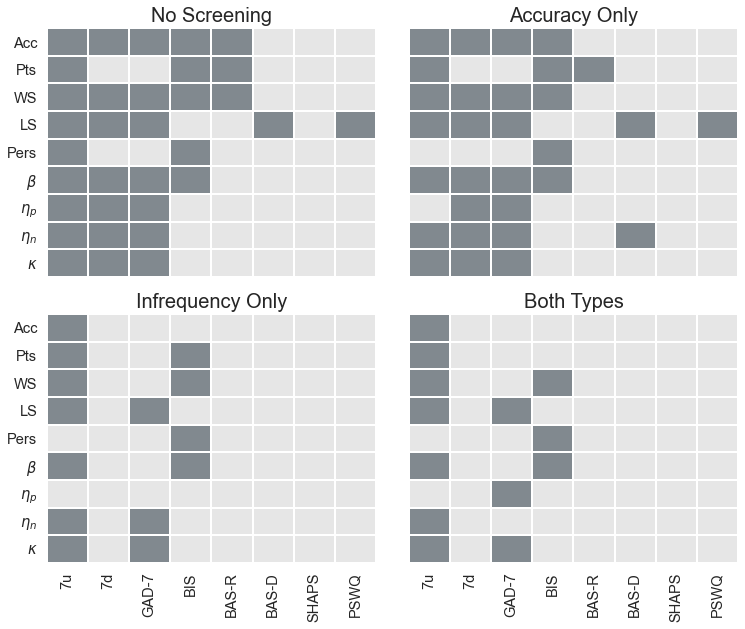

In [4]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from matplotlib.colors import ListedColormap
sns.set_theme('notebook', style='white', font='sans-serif', font_scale=1.33)
%matplotlib inline

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define canvas.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig = plt.figure(figsize=(12,9))

## Initialize panels.
gs = fig.add_gridspec(nrows=2, ncols=2, left=0.1, right=0.9, top=0.95, wspace=0.1, hspace=0.15)

## Define aesthetic features.
cmap = ListedColormap(['0.9','#81898f'])
annot_color = '0.99'
label_pad = 6

## Define labels.
xticklabels = ['7u', '7d', 'GAD-7', 'BIS', 'BAS-R', 'BAS-D', 'SHAPS', 'PSWQ']
yticklabels = ['Acc', 'Pts', 'WS', 'LS', 'Pers', r'$\beta$', r'$\eta_p$', r'$\eta_n$', r'$\kappa$'] 
titles = ['No Screening', 'Accuracy Only', 'Infrequency Only', 'Both Types']

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

for k in range(corr.shape[0]):
    
    ## Initialize axis.
    ax = plt.subplot(gs[k//2,k%2])
    
    ## Plot correlations.
    arr = np.where(corr[k] * (pval[k] < 0.05), 1, 0)
    sns.heatmap(arr, cmap=cmap, cbar=False, linecolor='w', linewidths=1, 
                xticklabels=xticklabels if k//2 else [],
                yticklabels=yticklabels if not k%2 else [], ax=ax)
    
    ## Add title.
    ax.set_title(titles[k], fontsize=20)
    
    ## Add annotations.
#     for i, j in np.array(np.where(arr)).T:
#         ax.text(j+0.5, i+0.5, '%0.2f' %corr[k,i,j], ha='center', va='center', fontsize=13, color=annot_color)

## Save figure.
plt.savefig(os.path.join('..','figures','main_03a.png'), dpi=180, transparent=True)

#### 3.2 Supplementary Tables

In [5]:
from pandas import DataFrame

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define tables.
tables = ['No Screening', 'Accuracy Only', 'Infrequency Only', 'Both Types']

## Define columns.
columns = ['7u', '7d', 'GAD-7', 'BIS', 'BAS-R', 'BAS-D', 'SHAPS', 'PSWQ']
index = ['Acc', 'Pts', 'WS', 'LS', 'Pers', r'$\beta$', r'$\eta_p$', r'$\eta_n$', r'$\kappa$'] 

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

for i, table in enumerate(tables):
    print(f'Constructing Table {i+1}: {table}.')

    ## Initialize table.
    fmt = lambda r, p: '%0.3f*' %r if p < 0.05 else '%0.3f' %r
    table = [fmt(r,p) for r, p in zip(corr[i].flatten(), pval[i].flatten())]
    table = np.array(table).reshape(corr[i].shape)
    
    ## Convert to DataFrame.
    table = DataFrame(table, index=index, columns=columns)

    ## Print LaTeX.
    print(table.to_latex())

Constructing Table 1: No Screening.
\begin{tabular}{lllllllll}
\toprule
{} &       7u &       7d &    GAD-7 &      BIS &    BAS-R &    BAS-D &   SHAPS &    PSWQ \\
\midrule
Acc      &  -0.295* &  -0.166* &  -0.093* &  -0.134* &  -0.128* &    0.054 &  -0.051 &  -0.037 \\
Pts      &  -0.225* &   -0.076 &   -0.023 &  -0.144* &  -0.125* &    0.003 &  -0.051 &   0.024 \\
WS       &  -0.327* &  -0.160* &  -0.129* &  -0.171* &  -0.086* &    0.048 &  -0.048 &  -0.062 \\
LS       &   0.285* &   0.158* &   0.146* &    0.050 &    0.028 &  -0.090* &   0.000 &  0.110* \\
Pers     &   0.134* &    0.066 &    0.032 &   0.166* &    0.083 &   -0.024 &   0.080 &  -0.004 \\
\$\textbackslash beta\$  &  -0.379* &  -0.163* &  -0.113* &  -0.183* &   -0.077 &    0.067 &  -0.066 &  -0.039 \\
\$\textbackslash eta\_p\$ &  -0.095* &  -0.106* &  -0.108* &   -0.020 &   -0.032 &   -0.021 &  -0.032 &  -0.050 \\
\$\textbackslash eta\_n\$ &   0.161* &   0.087* &   0.099* &   -0.045 &   -0.021 &   -0.083 &  -0.028 &   0.